In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate 
from keras import backend as K

import cv2
import os
from tqdm import tqdm

In [54]:
!ls img

0002cc93b.jpg  00031f466.jpg


In [376]:
from google.colab import files

uploaded = files.upload()

Saving 001982b08.jpg to 001982b08.jpg


In [0]:
!mv 001982b08.jpg img/

In [3]:
!ls

'0002cc93b (1).jpg'   00031f466.jpg   img	   'train (1).csv'
 0002cc93b.jpg	      adc.json	      sample_data   train.csv


In [4]:
!mkdir img
!mv 0002cc93b.jpg img
!mv 00031f466.jpg img

mkdir: cannot create directory ‘img’: File exists


In [195]:
!ls img

0002cc93b.jpg  00031f466.jpg


In [0]:
#convert the image to batches to solve memory error
path_csv = 'train.csv'   #complete path to csv data of images 
path_image_train = 'img/'  #complete path to training images
data_csv = pd.read_csv(path_csv)

In [0]:
IMG_HEIGHT = 256
IMG_WIDTH = 1600
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [0]:
data_enc = data_csv['EncodedPixels']
data_img_id = list(data_csv['ImageId'])

In [381]:
data_enc.shape

(7095,)

In [0]:
train_img = next(os.walk(path_image_train))[2]    #walk through all images in the path
#train_img.index('0a1cade03.jpg')                  #to get the index of an image id

In [0]:
x_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8())
y_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
img_with_mask = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32())

In [0]:
def rle2mask(rle, imgshape):
    #width & height of steel image
    width = imgshape[0]    
    height= imgshape[1]
    
    #flatttened empty array with size of input image
    mask= np.zeros( width*height ).astype(np.uint8)
    #convert all elements of encoded image pixels to int values
    array = np.asarray([int(x) for x in rle.split()])
    
    #splitting the encoded pixels
    #every odd index of encoded array is the start pixel &
    #every even index of encoded array is the length of the mask from start
    starts = array[0::2]
    lengths = array[1::2]
    
    #expanding the encoded pixel
    #current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        #current_position += lengths[index]
    
    #numpy operations to bring the shape of mask suitable to image
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [385]:
for i, img_id in tqdm(enumerate(train_img), total=len(train_img)):
    path = path_image_train + img_id
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resize = np.resize(img, (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    x_train[i] = img_resize     #store all the train images as numpy arrays for training
    
    #check whether an image has corresponding mask in the csv data or not
    if img_id in data_img_id:
        idx = data_img_id.index(img_id)
        #img_resize_1 = np.resize(img, (IMG_HEIGHT,IMG_WIDTH,1))
        y_train[i] = rle2mask(data_enc[idx], img_resize_1.shape)   #store all the masks as numpy arrays for training

100%|██████████| 3/3 [00:00<00:00, 100.31it/s]


In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
#U-net architecture
#convert the images to gray scale if reqd
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

In [388]:
model = build_model((256, 1600, 1))
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
conv2d_437 (Conv2D)             (None, 256, 1600, 8) 80          input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_438 (Conv2D)             (None, 256, 1600, 8) 584         conv2d_437[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_95 (MaxPooling2D) (None, 128, 800, 8)  0           conv2d_438[0][0]                 
___________________________________________________________________________________________

In [389]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0595 - dice_coef: 0.0088
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0383 - dice_coef: 0.0063
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0309 - dice_coef: 0.0048
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0280 - dice_coef: 0.0037
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0276 - dice_coef: 0.0029
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0274 - dice_coef: 0.0024
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0267 - dice_coef: 0.0024
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0257 - dice_coef: 0.0026
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0245 - dice_coef: 0.0030
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0233 - dice_coef: 0.0035


In [0]:
def predict(steel_img, mask_img, idx):
  pre = model.predict(steel_img)
  plt.figure(figsize=(50, 60))
  ax, fig = plt.subplots(1, 2)

  plt.subplot(1, 2, 1)
  plt.title("Original mask")
  plt.imshow(mask_img[idx])
  
  plt.subplot(1, 2, 2)
  plt.title("Predicted mask")
  plt.imshow(pre[idx].reshape(256, 1600))


<Figure size 3600x4320 with 0 Axes>

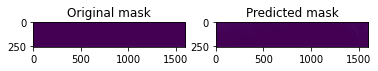

In [393]:
predict(x_train, y_train, 2)

In [0]:
p = model.predict(x_train)

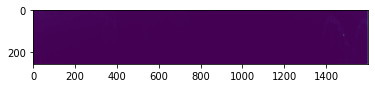

In [402]:
plt.imshow(p[2].reshape(256, 1600))

In [374]:
np.where(y_train[1] > 0)

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([333, 334, 335, ..., 344, 345, 346]))

In [373]:
np.where(pre[1] > 0)

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([   0,    1,    2, ..., 1597, 1598, 1599]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [335]:
x_train.shape

(2, 256, 1600, 1)

In [346]:
y_train.dtype

dtype('bool')

In [347]:
pre.dtype

dtype('float32')